# Mateusz Borowicz (2202830) - CE4145 NLP Coursework
## (04/11/2025)

# Section 1 - Dataset (200 Words)

The [vimal-quit tweet-eval-emotion dataset](https://huggingface.co/datasets/vimal-quilt/tweet-eval-emotion) is a relatively medium sized collection of 3257 records of tweets containing emotional messages. The dataset is essentially structured as a collection of text and label pairs. Even though it's not a multi-class dataset, I hope it will fit my coursework guidelines just fine with my consideration towards pre-processing and vectorization techniques. If I had more time, I would definitely focus on research towards a more complex dataset.

The task performed in this coursework is a simple binary text classification. The goal of this task is to predict the appropriate label as output, given the textual contents of social media posts as input. Each tweet is labeled with intensity of emotions ranged from 0 to 3, therefore making 4 unique categories for tweets:

0 - Low emotional involvment,
1 - Moderate emotional involvment,
2 - High emotional involvment,
3 - Extreme emotional involvment,

Each category from 0 to 3 follows from lowest to highest level of hierarchy, though the classiffiers could also be split into their own columns with "0" and "1" markings to represent boolean values.

## Load and Display the Dataset
Reference Link: https://huggingface.co/datasets/vimal-quilt/tweet-eval-emotion

In [ ]:
import numpy as np #import numpy for array functionality
import pandas as pd #import pandas for dataframes

from sklearn.pipeline import Pipeline # pipeline functionality
from sklearn.feature_extraction.text import CountVectorizer # simple pre-processing vectorizer
from sklearn.feature_extraction.text import TfidfTransformer #representation learner
from sklearn.neighbors import KNeighborsClassifier #simple classifier model
from sklearn.svm import SVC # Import Support Vector Classifier
from sklearn.model_selection import StratifiedKFold #The stratified version ensures that classes have equal representation across folds
from sklearn.metrics import accuracy_score #import an accuracy metric to tell us how well the model is doing

splits = {'train': 'train.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/vimal-quilt/tweet-eval-emotion/" + splits["train"])

# Display basic information about the dataset
display(df.shape) # rows, columns
display(df.head()) # first few records
display(df.info()) # Check types and null values

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(3257, 2)

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


None

In [4]:
# Use the 'text' and 'label' columns directly from the DataFrame
x = df['text'].values
y = df['label'].values

print(x.shape) #if we print the shape, we can see we have 1000 examples, each of which is associated with label
print(y.shape)

for i in range(0,5):
  print(x[i] +"\n") #check the input data (first 5 tweets)

(3257,)
(3257,)
“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry 

My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs 

No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu 

Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight 

it's pretty depressing when u hit pan on ur favourite highlighter 



## Section 2 - Representation Learning

Firstly I will split data into variables. Then I will approach to pre-process tweets with Tokenization, Normalization, Stop Words Removal and Lemminization

In [ ]:
import nltk #import the natural language toolkit

nltk.download('punkt') #download the package in nltk which supports tokenization
nltk.download('stopwords') #download the nltk package for stopwords
nltk.download('punkt_tab') # Download the missing resource

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import stopwords #import the package from the corpus
from nltk.stem.snowball import SnowballStemmer #import the snowball stemmer (also known as Porter2)
from sklearn.base import BaseEstimator, TransformerMixin

# Pre-processing function. Includes Tokenization, Normalization, Stop Word Removal and Stemmer
class pre_process(BaseEstimator, TransformerMixin):

    def __init__(self):
      return None #we do not need any parameters to instantiate this class

    def fit(self, X, y=None): #both fit and transform expect the data instances and labels to be called - we do not use the labels, so set y=None
        return self #as explained above, we will not use the fit method

    def transform(self, X, y=None):
      prep_text = []
      for x in X: #for each sentence in the whole dataset
            token_text = word_tokenize(x) #tokenize the document
            normd_text = [token.lower() for token in token_text if token.isalpha()] #list compression to apply some simple cleaning (lower case casting and punctuation removal) to tokenized terms

            swr_text = [token for token in normd_text if token not in stopwords.words('english')] #list compression to remove any stopwords from our list

            stemmer = SnowballStemmer("english") #specify we are using the English stemming rules, as other languages are present in toolkit
            prep_text += [[stemmer.stem(word) for word in swr_text]] #list compression for applying the stemmer

      prep_sentences = [" ".join(sentence) for sentence in prep_text] #we join the sentences back together to ensure compatibility with CountVec, which is doing some of it's own prep
      return prep_sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Section 3 - Algorithms (500 Words)

## Pipeline A: TfidfVectorizer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# List of classifiers to compare
classifiers = {
    'SVM': SVC(C=2),
    'kNN': KNeighborsClassifier(n_neighbors=50),
    'Logistic Regression': LogisticRegression(max_iter=10000), # Added Logistic Regression
    'Naive Bayes': MultinomialNB(alpha=0.5) # Added Multinomial Naive Bayes as another option
}

results = {}
all_scores = {} # Dictionary to store scores for boxplot

# Pipeline
for name, classifier in classifiers.items():
  print(f"Training and evaluating {name}...")
  text_clf = Pipeline([ #the pipeline object allows us to organise a series of functions which will be applied to our text data as though they were a single function
    ('preprocess', pre_process()), # Add the custom preprocessing step
    ('tfidf', TfidfVectorizer(lowercase=False, stop_words=None)), # Use TfidfVectorizer after custom preprocessing
    ('mod', classifier), # Use the current classifier
    ])

  acc_score = [] #create a list to store the accuracy values

  kf = StratifiedKFold(n_splits=5) #we instantiate the kfold instance, and set the number of folds to 5
  for train, test in kf.split(x,y): #we use a for loop to iterate through each fold using the train and test indexes from the dataset

    x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test] #things can get a bit weird when inputting indexes to functions, so lets save them as variables
    #print(train)
    #print(test) #this will print the train and test indexes respectively, if you want to be sure they do not overlap

    text_clf.fit(x_train, y_train) # Fit data to pipeline models
    predictions = text_clf.predict(x_test) # Save predictions
    acc = accuracy_score(predictions, y_test) # Calculate accuracy
    acc_score.append(acc) #we can append it to our list

  results[name] = np.mean(acc_score)
  all_scores[name] = acc_score # Store all scores for boxplot
  print(f"Mean Accuracy for {name}: {results[name]:.4f}")

Training and evaluating SVM...
Mean Accuracy for SVM: 0.6890
Training and evaluating kNN...
Mean Accuracy for kNN: 0.6460
Training and evaluating Logistic Regression...
Mean Accuracy for Logistic Regression: 0.6945
Training and evaluating Naive Bayes...
Mean Accuracy for Naive Bayes: 0.6417


## Evaluation (200 Words)
Depending on the task you adopt, there are several different ways you may wish to
evaluate the proposed NLP system. You should demonstrate your understanding by suggesting an appropriate
evaluation strategy here (which suits both the task and the data). The report should then conclude with a
description of the outcome of the comparison, alongside any appropriate visualisation. Review Weeks 4 – 8
for specific ideas, or Week 9 for ideas relating to explaining the outcomes of NLP systems


--- Comparison ---
SVM: 0.6890
kNN: 0.6466
Logistic Regression: 0.6945
Naive Bayes: 0.6417


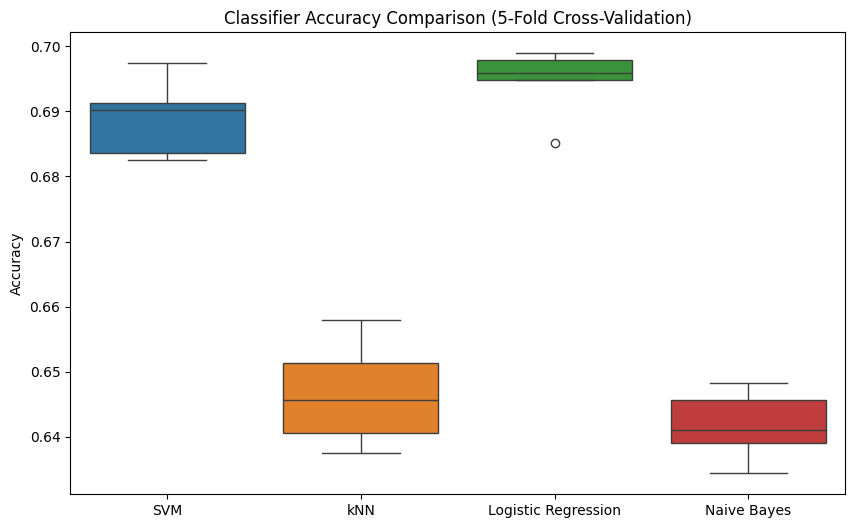

In [ ]:
print("\n--- Comparison ---")
for name, acc in results.items():
  print(f"{name}: {acc:.4f}")

# Generate Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(all_scores))
plt.title('Classifier Accuracy Comparison (5-Fold Cross-Validation)')
plt.ylabel('Accuracy')
plt.show()

# Task
Install the `transformers` and `accelerate` libraries, then prepare the text data from the `df` DataFrame for DistilBERT by tokenizing it and creating PyTorch `Dataset` and `DataLoader` instances. Afterward, train and fine-tune a `DistilBertForSequenceClassification` model on this data, ensuring that Weights & Biases logging is disabled. Evaluate the fine-tuned DistilBERT model on the test set, calculate its accuracy, and add these results to the `results` and `all_scores` dictionaries. Finally, update the comparative boxplot visualization to include DistilBERT's performance alongside the existing TF-IDF pipeline models, and provide a summary comparing the performance of the TF-IDF pipeline and the DistilBERT pipeline.

## Install Libraries

### Subtask:
Install the `transformers` and `accelerate` libraries required for working with DistilBERT models.


**Reasoning**:
The subtask is to install the `transformers` and `accelerate` libraries. I will use pip to install these libraries in a code cell.



In [10]:
pip install transformers accelerate

## Prepare Data for DistilBERT

### Subtask:
Tokenize the text data using a `DistilBertTokenizer` and prepare it into a format suitable for training a transformer model (e.g., PyTorch `Dataset` and `DataLoader`). This will handle splitting the data into training and test sets appropriately for DistilBERT.


**Reasoning**:
I need to import the necessary libraries, initialize the DistilBERT tokenizer, split the data into training and testing sets, tokenize the text data for both sets, and then define and instantiate a custom PyTorch Dataset for the tokenized data and labels to prepare it for model training.



In [11]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import torch

# Define the pre-trained DistilBERT model name
model_name = 'distilbert-base-uncased'

# Initialize the DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Split the x (text data) and y (labels) arrays into training and testing sets
x_train_bert, x_test_bert, y_train_bert, y_test_bert = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenize the training text data
train_encodings = tokenizer(list(x_train_bert), truncation=True, padding=True)

# Tokenize the test text data
test_encodings = tokenizer(list(x_test_bert), truncation=True, padding=True)

# Define a custom PyTorch Dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create instances of the EmotionDataset for training and test data
train_dataset = EmotionDataset(train_encodings, y_train_bert)
test_dataset = EmotionDataset(test_encodings, y_test_bert)

print("Data preparation for DistilBERT complete.")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Data preparation for DistilBERT complete.
Training dataset size: 2605
Test dataset size: 652


**Reasoning**:
Now that the data is prepared, I need to train and fine-tune a `DistilBertForSequenceClassification` model. This involves importing the necessary model and training components, defining training arguments, initializing the model with the correct number of labels, and setting up the `Trainer`.



In [12]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Get the number of unique labels from the dataset
num_labels = len(np.unique(y_train_bert))

# Initialize DistilBertForSequenceClassification model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none' # Disable Weights & Biases logging
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("DistilBERT model and Trainer initialized.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model and Trainer initialized.


**Reasoning**:
The previous code block successfully initialized the DistilBERT model and Trainer. To complete the task of training and fine-tuning the model, the `trainer.train()` method must be called. The `stderr` message was a warning, not an error, indicating that the classification head of the model is newly initialized and needs to be trained, which is precisely the next step.



In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Get the number of unique labels from the dataset
num_labels = len(np.unique(y_train_bert))

# Initialize DistilBertForSequenceClassification model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,                  # 3 should be enough before my deadline
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,       # keep at 1 if you run out of RAM
    learning_rate=3e-5,                  # higher = converges faster
    warmup_steps=0,                      # 0-100, above is unnecessary
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",         # only evaluate at end of each epoch
    save_strategy="epoch",               # saves less often
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",                    # keeps it fast
    fp16=True,                           # HUGE speed boost if you have a GPU (Colab free tier has it)
    dataloader_num_workers=2,            # helps data loading
    disable_tqdm=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("DistilBERT model and Trainer initialized.")

# Train the model
trainer.train()

print("DistilBERT model training complete.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model and Trainer initialized.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
